<h1 align='center'>I Don't Know - Where Do You Want to Eat?</h1>

<h1 align='center'>🍽️🤷‍♀️🤷‍♀️🤷‍♀️🥢</h1>

## Section 1) Introduction 📗

### It's a tough day at the office, and lunch time is here.  Have you ever had the following exchange with your co-workers and/ or friends?

#### 🤔: Where do you want to eat?
#### 🤨: I don't know.  Where do you want to eat?
#### 🙄: I don't know.  Where do you want to eat?

### And on and on and on 🤯.  Before you know it, lunch time is over, and it's time to get back to the gridstone.  You've spent most (if not all) of your lunch time simply trying to figure out where to eat.

#### We live in a world where we are faced with unprecidented choice in our options for entertainment, food, and habitation.  Being spolied for choice is a double-edged sword though.  In the face of so many options, people are often not happy with the choices that they make experiencing either buyer's remorse (fear of missing out aka FOMO) or being completely overwhelmed leading to analysis paralysis (AP).  My project (I Don't Know - Where Do You Want to Eat) aims to help lunch buddies solve the paradox of choice by implmeneting a hybrid recommender system (both content and collaborative filtering) to help find restaurants that meet the group's dining preferences and offering them 3 options that are close to their central location (the lunch buddies don't have to be at the same location).  The locations of the participants will be used to create a centroid (central location) between them that will be used in conjunction with queries the FourSquare API to return candidate restaurants fitting the top criteria of the diners.  I will then use the matrix factorization techique to create a sparse matrix that I will then feed to a LightFM model to fill in any blanks in the utilization matrix so that the top 3 recommendations can be returned and visualized.

## Section 2) Data 💾

### I will be using the following data sources to solve this problem:
#### - FourSquare API: To make calls to retrieve venues using the <a href='https://developer.foursquare.com/docs/api/venues/search'>`venues\search`</a> and <a href='https://developer.foursquare.com/docs/api/venues/details'>`venues\VENUEID`</a> endpoints.  This will be the basis for the item matrix that will help generate the utilization matrix as well as providing crucial information for the visualization of the final venue selections and their attributes (ratings, addresses, categories, etc.).  I will also make a call to the <a href='https://developer.foursquare.com/docs/api/venues/categories'>`venues\categories`</a>  endpoint to query all food venue category ids.  The users will also use this in order to construct their corresponding profiles.
#### - My dear friends and colleagues: My friends and colleauges have generously agreed to create user profiles along with their respective lunch time locations and dining preferences.  I will use this information along with the FourSquare Categories to create the user matrix.

In [1]:
# First things first
! conda install -c conda-forge folium --yes
! conda install -c conda-forge pandas-profiling --yes
! conda install -c conda-forge wordcloud --yes
! pip install lightfm
! pip install geocoder

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.10.0              |             py_0          59 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be INSTAL

In [2]:
# Let's get into it!

# standard weapons of choice
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import pandas_profiling

# for geolocation assistance
import geocoder

# for requesting
import requests

# all the viz
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

# for the hybrid recommender system
from lightfm import LightFM

%matplotlib inline

In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
# Creating the url for the categories API call
category_url = f'https://api.foursquare.com/v2/venues/categories?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}'

# Creating the nub of the Food category dataframe with the parent cat name and id
json_response = requests.get(category_url).json()
food_category = json_response['response']['categories'][3]
food_id_dataframe = json_normalize(food_category)
food_id_dataframe = food_id_dataframe[['id', 'name']]

# Filling out the rest of the Food category dataframe with all the children and their respective name and ids
food_categories = food_category['categories']
for i, cat in enumerate(food_categories, 1):
    food_id_dataframe.loc[i] = [cat['id'], cat['name']]

food_id_dataframe.set_index('name', inplace=True)

# Here is the completed food_id_dataframe
food_id_dataframe

,id
name,
Food,4d4b7105d754a06374d81259
Afghan Restaurant,503288ae91d4c4b30a586d67
African Restaurant,4bf58dd8d48988d1c8941735
American Restaurant,4bf58dd8d48988d14e941735
Asian Restaurant,4bf58dd8d48988d142941735
Australian Restaurant,4bf58dd8d48988d169941735
Austrian Restaurant,52e81612bcbc57f1066b7a01
BBQ Joint,4bf58dd8d48988d1df931735
Bagel Shop,4bf58dd8d48988d179941735


In [6]:
# ! pip install openpyxl # You may need to install this in your environment if it's not already included in your Anaconda distro

# Now to construct the user_feature matrix
user_category_df = food_id_dataframe.T
user_category_df.drop('id', axis=0, inplace=True)
user_category_df

# I need my friends and colleagues to add their user preferences for each restaurant category to the dataframe, so in order to collect their inputs I need an .xlsx version of the user_feature dataframe
user_category_df.to_excel('request_inputs.xlsx')

In [25]:
# Though the magic of time, my friends and colleagues have input their preferences for each cuisine.
# I gave my friends and colleauges instructions to fill out the user_category matrix with a rank of 1 - 5 (1 being lowest and 5 being highest).
# If my friend didn't have a preference or experience with a particular cuisine, I instructed them the leave the field blank.  The recommender system will take care of that.

# For when you're ready to get rid of that stupid 'Restaurant' category -_-'
# user_category_matrix_column_names = list((food.lower().replace(' ', '_') for food in food_id_dataframe[(food_id_dataframe.index != 'Food') | (food_id_dataframe.index != 'Restaurant')].index))
user_category_matrix_column_names = list((food for food in food_id_dataframe[food_id_dataframe.index != 'Food'].index))
user_category_matrix_column_names.insert(0, 'user_name')
user_category_matrix = pd.DataFrame(columns=user_category_matrix_column_names)

def build_user_category_matrix(user_info_list):
    '''
    Builds the user/category matrix which represents each user's preference for different cuisines
    '''
    user_category_dict = {}
    for user_cat, cat_name in zip(user_info_list, user_category_matrix_column_names):
        user_category_dict[cat_name] = user_cat
    user_category_matrix.loc[len(user_category_matrix)] = user_category_dict

elizabeth = ['Elizabeth', '', 4, 2, 5, 3, '', '', 4, 3, '', 2, 1, 4, 3, 2, 3, 2, 4, 5, '', 2, 2, 3, '', '', 1, 2, 1, 4, '', 3, 2, 3, 1, 1, 1, 2, 1, 4, 2, 1, '', 1, 3, '', 4, '', 4, 1, '', 5, 1, 4, '', 2, 1, 4, 1, 4, 4, 5, '', 1, '', 1, 1, '', '', 1, '', 3, 3, 2, '', '', 1, '', 1, 3, 4, '', 4, 1, '', 1, 1, 1, '', '', 5, 1]
jessica = ['Jessica', '', 3, 2, 4, '', '', 3, 1, 3, 2, 2, 4, 2, 1, 3, 1, 4, 5, 5, '', 5, 5, 2, '', 2, 1, 4, 1, 5, '', '', '', 3, 1, 3, '', 1, 3, 5, 1, 5, '', '', 2, '', 5, 4, 2, 1, '', 5, '', 4, 5, 4, 3, 3, 3, 5, 4, 5, '', 2, 4, 5, 3, '', '', '', '', '', 3, 4, '', '', 3, '', 3, 5, 5, 3, '', 2, '', 3, 5, 1, '', '', 4, 2]
anna = ['Anna', 5, 5, 1, 5, '', '', 4, 1, 1, 4, 3, 5, 5, 3, 4, 1, 5, 5, 5, '', 5, 4, 5, 5, 3, 5, 2, 4, 4, '', 5, 4, 5, 1, 3, 4, 1, 3, 4, 5, 4, 3, 4, 4, 5, 5, 5, '', 1, 3, 5, 3, 3, 5, 4, 5, 5, 1, 5, 5, 5, '', 5, 5, 1, 4, 3, '', 5, '', 4, 4, 1, '', '', 5, 3, 3, 4, 4, 5, '', 4, 4, 5, 3, 1, 5, 3, 3, 3]
candy = ['Candy', '', 1, 5, 5, '', 4, 4, 5, 5, '', 5, 5, 1, 1, 3, 1, 5, 4, '', '', 5, 5, 3, '', 4, 4, 5, 4, 3, '', '', 1, 1, 1, 4, 2, 1, 3, 4, 4, 4, 4, '', 4, 1, 3, 1, 3, 4, 2, 4, '', 5, 4, 1, 1, '', 3, 1, 5, 1, '', '', 1, 5, 5, 1, 1, 1, '', 1, 4, 4, 3, 1, 4, 1, 2, 4, 4, 3, 1, 5, 4, 4, 3, 2, 1, 1, 1, 1]
rosemary = ['Rosemary', 5, 5, 2, 4, '', 3, 1, 4, 3, 2, 4, 1, 5, 2, 1, 3, 4, 2, 3, 3, 4, 3, 5, '', 3, 3, 2, 4, 5, '', 3, 2, 4, 1, 1, 3, 2, 2, 4, 2, 1, 1, 2, 2, 3, 3, 3, 4, 1, 2, 5, 1, 3, 4, 1, 3, 4, 1, 3, 2, 4, 3, 5, 5, 4, 2, 1, '', 3, 4, 3, 3, 3, 4, 2, 5, '', 3, 4, 4, 3, 5, 1, '', 5, 3, 2, 2, 2, 5, 1]
jessie = ['Jessie', 1, 5, 3, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3, 2, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 5, 1, 1, 1, 4, 3, 2, 3, '', '', '', 1, 4, 5, 5, 1, 1, 1, 5, 1, 4, 5, 5, 5, 4, 1, 5, 1, 5, 2, 1, '', '', '', '', '', '', 3, '', 4, '', 1, 1, '', '', '', '', 1, '', 3, '', '', '', '', '', '', '', 5, '']
jonnie = ['Jonnie', '', 4, 5, 4, '', '', 5, 5, 2, '', 3, 5, 1, 3, 5, 2, 2, 4, 1, '', 1, 5, 3, '', 4, 1, 5, 1, 5, '', '', '', 5, 3, 5, 2, 1, 3, 3, '', 4, '', 5, 1, 2, 5, 4, 1, 1, '', 4, 4, 4, 5, 1, 4, 5, 1, 5, 5, 5, '', '', 4, 1, 4, '', '', 4, 5, '', 4, 4, '', '', 5, '', 1, 4, 4, 4, '', 4, '', 2, 2, 1, '', '', 4, 3]
natalie = ['Natalie', 1, 5, 4, 5, 3, 2, 5, 3, 3, 2, 3, 4, 4, 4, 5, 3, 3, 5, 5, 1, 2, 5, 3, 2, 3, 2, 4, 2, 4, 3, 3, 3, 4, 3, 3, 2, 1, 1, 3, 2, 5, 3, 4, 2, 2, 3, 3, 4, 2, 2, 4, 2, 4, 2, 3, 4, 5, 4, 4, 5, 3, 2, 3, 3, 2, 4, 3, 3, 2, 4, 2, 4, 3, 2, 2, 5, 2, 2, 3, 5, 5, 2, 5, 2, 2, 3, 2, 1, 1, 4, 5]
imo = ['Imo', '', 5, 3, 4, 2, '', 3, 4, 5, '', 3, 4, 2, 2, 3, 2, 3, 4, '', '', 3, 4, '', '', '', 4, 4, 3, 3, '', '', 3, 3, 2, 3, '', 3, 3, 2, '', 4, 4, '', 3, 2, '', 3, '', 1, '', 4, '', 3, '', 2, 3, 4, '', 3, 5, 3, 3, '', '', 2, 4, '', '', 4, 3, '', 2, 3, '', '', 1, '', 2, 2, 4, 3, '', 2, '', '', 2, 1, '', '', 3, 3]
eric = ['Eric', '', 3, 4, 4, '', '', 4, 3, 3, 2, 3, 5, 1, 2, 5, 2, 3, 3, 4, '', 2, 4, 2, '', 4, 2, 3, 3, 3, 3, 1, 2, 2, 3, 2, 2, 3, 3, 3, 2, 5, '', '', 2, '', 4, '', 3, 5, '', 5, 2, 5, '', 3, 2, 4, 2, '', 5, 2, '', '', '', '', 5, '', 3, 1, 5, 1, 4, 4, '', 2, 2, '', 3, 4, 5, 3, 2, 5, '', '', 2, 2, '', 2, 2, 5]
shelan = ['Shelan', 2, 5, 5, 5, 3, 3, 4, 2, 5, 3, 4, 5, 5, 3, 4, 2, 4, 3, 4, 3, 3, 3, 4, 2, 2, 4, 4, 4, 3, 3, 3, 4, 4, 3, 4, 3, 2, 3, 4, 4, 4, 3, 3, 3, 2, 4, 4, 4, 3, 2, 2, 4, 5, 2, 3, 4, 4, 3, 4, 5, 4, 4, 3, 3, 2, 4, 3, 3, 2, 4, 2, 3, 3, 2, 2, 1, '', 3, 2, 2, 3, 3, 3, 3, 4, 3, 2, 3, 2, 5, 3]
shari = ['Shari', '', 5, 5, 5, '', '', 5, 3, 3, 5, 4, 5, 5, 3, 4, 1, 3, 5, 3, '', 3, 5, 4, '', 5, 3, 3, 4, 4, '', 4, 1, 1, 2, 2, 3, 2, 2, 5, 3, 5, '', '', '', 1, 4, 3, 3, 3, '', 2, 3, 5, '', 4, 3, 4, 4, 5, 5, '', '', '', '', 3, 3, 3, '', 1, 5, '', 3, 4, '', 1, 4, '', 4, 5, 5, 5, '', 4, '', 3, 1, 1, '', '', 1, 3]
andre = ['Andre', 3, 4, 4, 5, '', 3, 4, 2, 3, 3, 3, 2, 4, 1, 4, 1, 3, 5, 5, 1, 3, 5, 1, '', 3, 1, 2, 1, 5, '', 3, 2, 4, 2, 2, 3, 2, 3, 3, 5, 4, 3, 3, 3, 1, 4, 4, 4, 2, '', 5, 2, 5, '', 2, 4, 5, 1, 5, 5, 4, 3, 3, '', 1, 4, 3, 4, 3, 5, 2, 4, 4, 3, 1, 5, '', 1, 5, 5, 4, '', 3, '', 3, 2, 1, 3, '', 3, 2]
tina_marie = ['Tina-Marie', '', 5, 5, 5, 1, 2, 5, 1, 1, 3, 5, 5, 2, 1, 5, '', 3, 5, 5, '', 4, 4, 4, 2, 5, 5, 5, 2, 3, 3, 2, 1, 5, 3, 4, 5, 2, 3, 3, 2, 3, 2, 3, 1, 5, 5, 4, 2, 1, 1, 4, 2, 4, 3, 5, 5, 5, 4, 5, 4, 4, 2, 2, 3, '', 5, 1, 3, 1, 5, 1, 5, 4, 2, 1, 5, '', 5, 5, 4, 3, '', 4, 2, 4, 2, '', '', '', 4, 4]

# adding the users to the sparse matrix
build_user_category_matrix(elizabeth)
build_user_category_matrix(jessica)
build_user_category_matrix(anna)
build_user_category_matrix(candy)
build_user_category_matrix(rosemary)
build_user_category_matrix(jessie)
build_user_category_matrix(jonnie)
build_user_category_matrix(imo)
build_user_category_matrix(natalie)
build_user_category_matrix(eric)
build_user_category_matrix(shelan)
build_user_category_matrix(shari)
build_user_category_matrix(andre)
build_user_category_matrix(tina_marie)

user_category_matrix.set_index('user_name', inplace=True)
user_category_matrix

,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,...,Sri Lankan Restaurant,Steakhouse,Swiss Restaurant,Tea Room,Theme Restaurant,Truck Stop,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
user_name,,,,,,,,,,,,,,,,,,,,,
Elizabeth,,4,2,5,3,,,4,3,,...,4,1,,1,1,1,,,5,1
Jessica,,3,2,4,,,3,1,3,2,...,,2,,3,5,1,,,4,2
Anna,5,5,1,5,,,4,1,1,4,...,,4,4,5,3,1,5,3,3,3
Candy,,1,5,5,,4,4,5,5,,...,1,5,4,4,3,2,1,1,1,1
Rosemary,5,5,2,4,,3,1,4,3,2,...,5,1,,5,3,2,2,2,5,1
Jessie,1,5,3,4,1,1,1,1,1,1,...,3,,,,,,,,5,
Jonnie,,4,5,4,,,5,5,2,,...,,4,,2,2,1,,,4,3
Imo,,5,3,4,2,,3,4,5,,...,,2,,,2,1,,,3,3
Natalie,1,5,4,5,3,2,5,3,3,2,...,2,5,2,2,3,2,1,1,4,5


In [26]:
# I also have the preferences of the users who submitted profiles

user_pref_column_names = ['user_name', 'loc_name', 'loc_address', 'pref_1', 'pref_2', 'pref_3', 'pref_4', 'pref_5']

user_loc_pref_df = pd.DataFrame(columns=user_pref_column_names)

def add_user_pref(user_list):
    '''
    Adds individual users to the user_loc_pref_df
    '''
    user_dict = {}
    for col, user in zip(user_pref_column_names, user_list):
        user_dict[col] = user
    user_loc_pref_df.loc[len(user_loc_pref_df)] = user_dict

jessica_pref = ['Jessica', 'Amazon Doppler', '2021 7th Ave, Seattle, WA 98121', 'Asian Restaurant', 'Food Truck', 'Greek Restaurant', 'Indian Restaurant', 'Mediterranean Restaurant']
candy_pref = ['Candy', 'The Park Place Building', '1200 6th Ave, Seattle, WA 98101', 'American Restaurant', 'Dumpling Restaurant', 'Italian Restaurant', 'Pizza Place', 'Steakhouse']
jessie_pref = ['Jessie', 'The IBM Building', '1200 5th Ave, Seattle, WA 98101', 'Greek Restaurant', 'Indian Restaurant', 'Mediterranean Restaurant', 'Middle Eastern Restaurant', 'Vegetarian / Vegan Restaurant']
elizabeth_pref = ['Elizabeth', 'Amazon Doppler', '2021 7th Ave, Seattle, WA 98121', 'Asian Restaurant', 'Indian Restaurant', 'Middle Eastern Restaurant', 'Soup Place', 'Vegetarian / Vegan Restaurant']
anna_pref = ['Anna', 'The Walt Disney Company', '925 4th Ave, Seattle, WA 98104', 'Indian Restaurant', 'Mediterranean Restaurant', 'Molecular Gastronomy Restaurant', 'Tea Room', 'Turkish Restaurant']
rosemary_pref = ['Rosemary', 'Westlake Center', '400 Pine St, Seattle, WA 98101', 'African Restaurant', 'Bubble Tea Shop', 'Dumpling Restaurant', 'Seafood Restaurant', 'Vegetarian / Vegan Restaurant']
jonnie_pref = ['Jonnie', 'Impact Hub', '220 2nd Ave S, Seattle, WA 98104', 'Asian Restaurant', 'BBQ Joint', 'Diner', 'Fish & Chips Shop', 'Mexican Restaurant']
natalie_pref = ['Natalie', 'Fred Hutch', '1100 Fairview Ave N, Seattle, WA 98109', 'Wings Joint', 'Mexican Restaurant', 'Gastropub', 'Burger Joint', 'Asian Restaurant']
imo_pref = ['Imo', 'Impact Hub', '220 2nd Ave S, Seattle, WA 98104', 'African Restaurant', 'Asian Restaurant', 'Indian Restaurant', 'Mexican Restaurant', 'Southern / Soul Food Restaurant']
eric_pref = ['Eric', 'King Street Station', '303 S Jackson St, Seattle, WA 98104', 'Fried Chicken Joint', 'Italian Restaurant', 'Mexican Restaurant', 'Southern / Soul Food Restaurant', 'Wings Joint']
shelan_pref = ['Shelan', 'CenturyLink Field', '800 Occidental Ave S, Seattle, WA 98134', 'African Restaurant', 'American Restaurant', 'Caribbean Restaurant', 'Tea Room', 'Vegetarian / Vegan Restaurant']
shari_pref = ['Shari', 'Impact Hub', '220 2nd Ave S, Seattle, WA 98104', 'African Restaurant', 'Asian Restaurant', 'Italian Restaurant', 'Mexican Restaurant', 'Southern / Soul Food Restaurant']
andre_pref = ['Andre', 'Impact Hub', '220 2nd Ave S, Seattle, WA 98104', 'Southern / Soul Food Restaurant', 'Mexican Restaurant', 'Mediterranean Restaurant', 'Indian Restaurant', 'Asian Restaurant']
tina_marie_pref = ['Tina-Marie', 'Odd Fellows Builiding', '915 E Pine St, Seattle, WA 98122', 'African Restaurant', 'American Restaurant', 'Gluten-free Restaurant', 'Latin American Restaurant', 'Middle Eastern Restaurant']

add_user_pref(jessica_pref)
add_user_pref(candy_pref)
add_user_pref(jessie_pref)
add_user_pref(elizabeth_pref)
add_user_pref(anna_pref)
add_user_pref(rosemary_pref)
add_user_pref(jonnie_pref)
add_user_pref(natalie_pref)
add_user_pref(imo_pref)
add_user_pref(eric_pref)
add_user_pref(shelan_pref)
add_user_pref(shari_pref)
add_user_pref(andre_pref)
add_user_pref(tina_marie_pref)

user_loc_pref_df.set_index('user_name', inplace=True)
user_loc_pref_df

,loc_name,loc_address,pref_1,pref_2,pref_3,pref_4,pref_5
user_name,,,,,,,
Jessica,Amazon Doppler,"2021 7th Ave, Seattle, WA 98121",Asian Restaurant,Food Truck,Greek Restaurant,Indian Restaurant,Mediterranean Restaurant
Candy,The Park Place Building,"1200 6th Ave, Seattle, WA 98101",American Restaurant,Dumpling Restaurant,Italian Restaurant,Pizza Place,Steakhouse
Jessie,The IBM Building,"1200 5th Ave, Seattle, WA 98101",Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant
Elizabeth,Amazon Doppler,"2021 7th Ave, Seattle, WA 98121",Asian Restaurant,Indian Restaurant,Middle Eastern Restaurant,Soup Place,Vegetarian / Vegan Restaurant
Anna,The Walt Disney Company,"925 4th Ave, Seattle, WA 98104",Indian Restaurant,Mediterranean Restaurant,Molecular Gastronomy Restaurant,Tea Room,Turkish Restaurant
Rosemary,Westlake Center,"400 Pine St, Seattle, WA 98101",African Restaurant,Bubble Tea Shop,Dumpling Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant
Jonnie,Impact Hub,"220 2nd Ave S, Seattle, WA 98104",Asian Restaurant,BBQ Joint,Diner,Fish & Chips Shop,Mexican Restaurant
Natalie,Fred Hutch,"1100 Fairview Ave N, Seattle, WA 98109",Wings Joint,Mexican Restaurant,Gastropub,Burger Joint,Asian Restaurant
Imo,Impact Hub,"220 2nd Ave S, Seattle, WA 98104",African Restaurant,Asian Restaurant,Indian Restaurant,Mexican Restaurant,Southern / Soul Food Restaurant


In [28]:
# Now to add the longitude and latitude of each of the users' locations
user_loc_pref_df.index
for user, address in zip(user_loc_pref_df.index, user_loc_pref_df['loc_address']):
    location = geocoder.arcgis(address)
    user_loc_pref_df.at[user, 'loc_lat'] = location.latlng[0]
    user_loc_pref_df.at[user, 'loc_lng'] = location.latlng[1]

user_loc_pref_df

,loc_name,loc_address,pref_1,pref_2,pref_3,pref_4,pref_5,loc_lat,loc_lng
user_name,,,,,,,,,
Jessica,Amazon Doppler,"2021 7th Ave, Seattle, WA 98121",Asian Restaurant,Food Truck,Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,47.615461,-122.338238
Candy,The Park Place Building,"1200 6th Ave, Seattle, WA 98101",American Restaurant,Dumpling Restaurant,Italian Restaurant,Pizza Place,Steakhouse,47.608968,-122.332448
Jessie,The IBM Building,"1200 5th Ave, Seattle, WA 98101",Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,47.608288,-122.333385
Elizabeth,Amazon Doppler,"2021 7th Ave, Seattle, WA 98121",Asian Restaurant,Indian Restaurant,Middle Eastern Restaurant,Soup Place,Vegetarian / Vegan Restaurant,47.615461,-122.338238
Anna,The Walt Disney Company,"925 4th Ave, Seattle, WA 98104",Indian Restaurant,Mediterranean Restaurant,Molecular Gastronomy Restaurant,Tea Room,Turkish Restaurant,47.605826,-122.332736
Rosemary,Westlake Center,"400 Pine St, Seattle, WA 98101",African Restaurant,Bubble Tea Shop,Dumpling Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,47.611338,-122.337339
Jonnie,Impact Hub,"220 2nd Ave S, Seattle, WA 98104",Asian Restaurant,BBQ Joint,Diner,Fish & Chips Shop,Mexican Restaurant,47.600469,-122.331549
Natalie,Fred Hutch,"1100 Fairview Ave N, Seattle, WA 98109",Wings Joint,Mexican Restaurant,Gastropub,Burger Joint,Asian Restaurant,47.628798,-122.330790
Imo,Impact Hub,"220 2nd Ave S, Seattle, WA 98104",African Restaurant,Asian Restaurant,Indian Restaurant,Mexican Restaurant,Southern / Soul Food Restaurant,47.600469,-122.331549


In [29]:
# let's just return a subset of the people we want to be lunch buddies
def select_users(user_list):
    '''
    Returns a subset of the user_loc_pref_df for just the users we want to be lunch buddies
    '''
    return user_loc_pref_df.loc[user_list]

lunch_buddies = ['Elizabeth', 'Jessica', 'Anna', 'Candy', 'Rosemary', 'Jessie', 'Jonnie', 'Natalie', 'Imo', 'Eric', 'Shelan', 'Shari', 'Andre', 'Tina-Marie']
buddies_df = select_users(lunch_buddies)
buddies_df

,loc_name,loc_address,pref_1,pref_2,pref_3,pref_4,pref_5,loc_lat,loc_lng
user_name,,,,,,,,,
Elizabeth,Amazon Doppler,"2021 7th Ave, Seattle, WA 98121",Asian Restaurant,Indian Restaurant,Middle Eastern Restaurant,Soup Place,Vegetarian / Vegan Restaurant,47.615461,-122.338238
Jessica,Amazon Doppler,"2021 7th Ave, Seattle, WA 98121",Asian Restaurant,Food Truck,Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,47.615461,-122.338238
Anna,The Walt Disney Company,"925 4th Ave, Seattle, WA 98104",Indian Restaurant,Mediterranean Restaurant,Molecular Gastronomy Restaurant,Tea Room,Turkish Restaurant,47.605826,-122.332736
Candy,The Park Place Building,"1200 6th Ave, Seattle, WA 98101",American Restaurant,Dumpling Restaurant,Italian Restaurant,Pizza Place,Steakhouse,47.608968,-122.332448
Rosemary,Westlake Center,"400 Pine St, Seattle, WA 98101",African Restaurant,Bubble Tea Shop,Dumpling Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,47.611338,-122.337339
Jessie,The IBM Building,"1200 5th Ave, Seattle, WA 98101",Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,47.608288,-122.333385
Jonnie,Impact Hub,"220 2nd Ave S, Seattle, WA 98104",Asian Restaurant,BBQ Joint,Diner,Fish & Chips Shop,Mexican Restaurant,47.600469,-122.331549
Natalie,Fred Hutch,"1100 Fairview Ave N, Seattle, WA 98109",Wings Joint,Mexican Restaurant,Gastropub,Burger Joint,Asian Restaurant,47.628798,-122.330790
Imo,Impact Hub,"220 2nd Ave S, Seattle, WA 98104",African Restaurant,Asian Restaurant,Indian Restaurant,Mexican Restaurant,Southern / Soul Food Restaurant,47.600469,-122.331549


In [30]:
# Let's find the central location of the lunch buddies.  This will be done by getting the mean latitude and longitude of all the users.
def get_central_loc(user_list):
    '''
    Returns the central location of the lunch buddies
    '''
    central_lat = user_loc_pref_df['loc_lat'][user_list].mean()
    central_lng = user_loc_pref_df['loc_lng'][user_list].mean()
    return(central_lat, central_lng)

central_location = get_central_loc(lunch_buddies)
central_location

(47.60753606712531, -122.33231018259455)

In [31]:
def get_lunch_buddy_sparse_matrix(user_list):
    '''
    Returns the sparse matrix of the selected lunch buddies
    '''
    return user_category_matrix.loc[user_list]

buddy_sparse_matrix = get_lunch_buddy_sparse_matrix(lunch_buddies)
buddy_sparse_matrix

,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,...,Sri Lankan Restaurant,Steakhouse,Swiss Restaurant,Tea Room,Theme Restaurant,Truck Stop,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
user_name,,,,,,,,,,,,,,,,,,,,,
Elizabeth,,4,2,5,3,,,4,3,,...,4,1,,1,1,1,,,5,1
Jessica,,3,2,4,,,3,1,3,2,...,,2,,3,5,1,,,4,2
Anna,5,5,1,5,,,4,1,1,4,...,,4,4,5,3,1,5,3,3,3
Candy,,1,5,5,,4,4,5,5,,...,1,5,4,4,3,2,1,1,1,1
Rosemary,5,5,2,4,,3,1,4,3,2,...,5,1,,5,3,2,2,2,5,1
Jessie,1,5,3,4,1,1,1,1,1,1,...,3,,,,,,,,5,
Jonnie,,4,5,4,,,5,5,2,,...,,4,,2,2,1,,,4,3
Natalie,1,5,4,5,3,2,5,3,3,2,...,2,5,2,2,3,2,1,1,4,5
Imo,,5,3,4,2,,3,4,5,,...,,2,,,2,1,,,3,3


In [82]:
# What to do about people at the same location?  Let's group them for mapping purposes
def check_for_dupe_locs():
    '''
    Checks for users in the user_loc_pref_df who are located at the same location
    '''
    users_at_same_loc = buddies_df.loc[buddies_df.duplicated(subset=['loc_lat', 'loc_lng'], keep=False), :]
    if len(users_at_same_loc) > 0:
        users_at_same_loc = users_at_same_loc[['loc_lat', 'loc_lng', 'loc_name', 'loc_address']]
        users_at_same_loc = users_at_same_loc.groupby(['loc_lat', 'loc_lng', 'loc_name', 'loc_address'], as_index=False).apply(lambda x: ' and '.join(x.index))
        if isinstance(users_at_same_loc.unstack().loc[users_at_same_loc.unstack().index[0], users_at_same_loc.unstack().columns[0]], float):
            return users_at_same_loc.unstack().loc[::,::-1]
        elif isinstance(users_at_same_loc.unstack().loc[users_at_same_loc.unstack().index[0], users_at_same_loc.unstack().columns[0]], str):
            return users_at_same_loc.unstack()
    else:
        return None

users_at_same_loc = check_for_dupe_locs()

for i, address in enumerate(users_at_same_loc):
    buddies = users_at_same_loc.loc[:, address][i] # access the lunch buddies
    lat = users_at_same_loc.index[i][0] # access the lat of the index
    lng = users_at_same_loc.index[i][1] # access the lng of the index
    loc = users_at_same_loc.index[i][2] # access the loc of the index
    print(f'{buddies} are at {loc}, which is located at ({lat}, {lng}).')

Jonnie and Imo and Shari and Andre are at Impact Hub, which is located at (47.60046941909516, -122.33154927058703).
Elizabeth and Jessica are at Amazon Doppler, which is located at (47.61546074825446, -122.33823801722535).


In [45]:
# Let's map out Seattle, WA USA
seattle_wa = geocoder.arcgis('Seattle, WA')

seattle_lat, seattle_lng = seattle_wa.latlng[0], seattle_wa.latlng[1] 
seattle_map = folium.Map(location=(seattle_lat, seattle_lng), zoom_start=14)

def create_initial_map(user_dataframe):
    '''
    Creates an initial map of where the lunch buddies are located
    '''
    for lat, lng, uname, locname in zip(user_dataframe['loc_lat'], user_dataframe['loc_lng'], user_dataframe.index, user_dataframe['loc_name']):
            folium.CircleMarker(location=(lat, lng), popup= f'{uname} is located at {locname}').add_to(seattle_map)
    if len(users_at_same_loc) > 0:
        for i, address in enumerate(users_at_same_loc):
            buddies = users_at_same_loc.loc[:, address][i] # access the lunch buddies
            lat = users_at_same_loc.index[i][0] # access the lat of the index
            lng = users_at_same_loc.index[i][1] # access the lng of the index
            loc = users_at_same_loc.index[i][2] # access the loc of the index
            folium.CircleMarker(location=(lat, lng), popup= f'{buddies} are located at {loc}').add_to(seattle_map)

    folium.CircleMarker(location=(central_location[0], central_location[1]), popup=f'This is the central location', color='green').add_to(seattle_map)

create_initial_map(buddies_df)
seattle_map


# use when mapping out the venues    
# icon = folium.features.CustomIcon('https://ss3.4sqi.net/img/categories_v2/food/cafe_bg_32.png', icon_size=(32, 32))
# folium.Marker(location=(central_location[0], central_location[1]), popup=f'This is the central location', icon=icon, color='green').add_to(seattle_map)


In [46]:
def create_target_users_score_matrix(user_dataframe):
    '''
    Creates a matrix of each lunch buddy's cuisine preference score
    '''
    pref_list = []
    prefs_df = user_dataframe[['pref_1', 'pref_2', 'pref_3', 'pref_4', 'pref_5']]
    for user in user_dataframe.index:
        for pref in prefs_df.columns:
            pref_list.append(prefs_df.loc[user, pref])

    pref_set = set(pref_list)
    pref_list = list(pref_set)
    user_list = user_dataframe.index.to_list()
    
    user_pref_score_matrix = pd.DataFrame(columns=pref_list, index=user_list)
    
    for user in user_list:
        for pref in pref_list:
            users_preference = user_category_matrix.loc[user, pref]
            user_pref_score_matrix.loc[user, pref] = users_preference
    
    return user_pref_score_matrix

user_score_matrix = create_target_users_score_matrix(buddies_df)
user_score_matrix

,Bubble Tea Shop,Burger Joint,Vegetarian / Vegan Restaurant,Seafood Restaurant,Turkish Restaurant,Molecular Gastronomy Restaurant,American Restaurant,BBQ Joint,Southern / Soul Food Restaurant,Dumpling Restaurant,...,African Restaurant,Soup Place,Mexican Restaurant,Fish & Chips Shop,Indian Restaurant,Mediterranean Restaurant,Diner,Tea Room,Pizza Place,Gluten-free Restaurant
Elizabeth,4,2,5,1,,1,2,,4,4,...,4,3,4,1,5,4,2,1,1,
Jessica,2,3,4,3,,2,2,3,5,5,...,3,5,4,3,5,5,4,3,3,
Anna,5,4,3,5,5,5,1,4,4,4,...,5,4,5,3,5,5,2,5,4,5
Candy,1,3,1,4,1,,5,4,4,3,...,1,4,5,4,4,1,5,4,5,1
Rosemary,5,1,5,5,2,5,2,1,4,5,...,5,4,2,1,5,3,2,5,2,3
Jessie,1,2,5,,,1,3,1,1,1,...,5,,1,1,5,5,2,,,4
Jonnie,1,5,4,5,,,5,5,4,5,...,4,4,5,5,4,5,5,2,4,2
Natalie,4,5,4,5,1,3,4,5,5,4,...,5,3,5,3,4,4,4,2,4,2
Imo,2,3,3,1,,,3,3,4,3,...,5,2,5,3,4,3,4,,4,2
Eric,1,5,2,2,,,4,4,5,3,...,3,4,5,2,5,,3,,5,


In [47]:
def create_composite_user(score_matrix):
    '''
    Returns a series of the composite ranking of each cusine's ranking by all of the lunch buddies.
    '''
    return score_matrix.sum(axis=0).sort_values(ascending=False)

composite_user = create_composite_user(user_score_matrix)
composite_user

Asian Restaurant                   64
Mexican Restaurant                 60
Indian Restaurant                  59
African Restaurant                 59
Italian Restaurant                 58
Southern / Soul Food Restaurant    56
Dumpling Restaurant                52
American Restaurant                50
Burger Joint                       50
Food Truck                         49
Vegetarian / Vegan Restaurant      49
Diner                              47
Bubble Tea Shop                    42
Fish & Chips Shop                  38
dtype: int64

In [48]:
# Let's get a nice silhouette image
# IMPORTANT!  THE MASK HAS TO BE A BLACK AND WHITE IMAGE!  NO COLORS!  NO TRANSPARENT BACKGROUNDS!
# THE WORD CLOUD WILL BE RENDERED ONTO THE BLACK PARTS OF THE IMAGE!
! wget --quiet https://image.freepik.com/free-icon/oriental-bowl-chopsticks_318-9695.jpg -O bowl_silhouette.jpg
! wget --quiet https://png2.cleanpng.com/sh/ad2e1971b50358d76e8bc84b657a7922/L0KzQYm3VsEzN5lwipH0aYP2gLBuTfZwepwyg9DyZnWwc8b7jPVzgV51hNN9ZT31f8rojL1kaaNuetRuYX6wc8P8igNme146eqNvNEi6c7SCUsg3PF83UKcBOUW7RYK8Usg4P2c9SqoDMkSxgLBu/kisspng-fork-knife-cutlery-plate-royal-caribbean-cruises-5b1f487cc92864.285695851528776828824.png -O fork_and_knife.png
! wget --quiet https://static.vecteezy.com/system/resources/previews/000/532/635/large_2x/vector-waiter-waitress-serve-icon-dish-up.jpg -O waiter.jpg
! wget --quiet https://res.cloudinary.com/teepublic/image/private/s--Am50TV5---/c_crop,x_10,y_10/c_fit,w_1109/c_crop,g_north_west,h_1260,w_1260,x_-76,y_-94/co_rgb:ffffff,e_colorize,u_Misc:One Pixel Gray/c_scale,g_north_west,h_1260,w_1260/fl_layer_apply,g_north_west,x_-76,y_-94/bo_157px_solid_white/e_overlay,fl_layer_apply,h_1260,l_Misc:Art Print Bumpmap,w_1260/e_shadow,x_6,y_6/c_limit,h_1134,w_1134/c_lpad,g_center,h_1260,w_1260/b_rgb:eeeeee/c_limit,f_jpg,h_630,q_90,w_630/v1547259589/production/designs/3947399_0.jpg -O steaming_bowl.jpg

! ls -a

.   bowl_silhouette.jpg  request_inputs.xlsx  waiter.jpg
..  fork_and_knife.png	 steaming_bowl.jpg


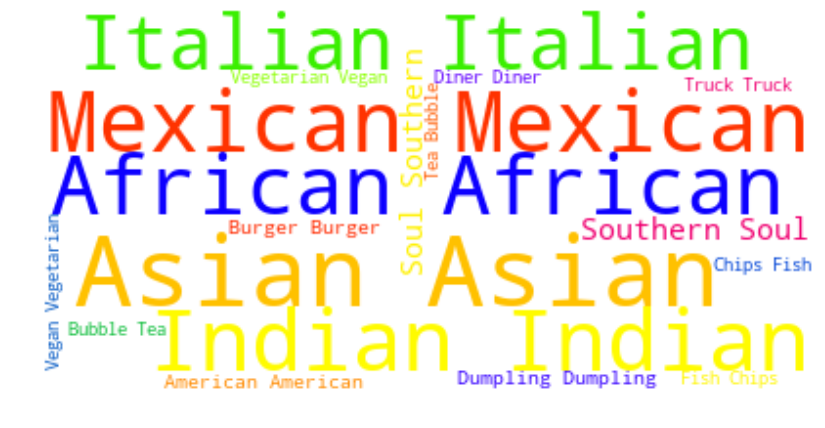

In [56]:
def cuisine_word_cloud(composite):
    food_word_cloud_mask = np.array(Image.open('bowl_silhouette.jpg'))
    stop_words = (['Restaurant', 'Joint', 'Shop', 'Spot', 'Food', 'Place'])
    composite_word = ''
    
    word_cloud_array = []
    composite_dict = composite.to_dict()
    for key, value in composite_dict.items():
        for i in range(value):
            word_cloud_array.append(key)
    composite_word = ' '.join(word_cloud_array)
    
    food_word_cloud = WordCloud(background_color='white',
                                stopwords=stop_words,
                                colormap=plt.cm.prism)
#                                 mask=food_word_cloud_mask, )

    food_word_cloud.generate(composite_word)

    fig = plt.figure(figsize=(14,18))

    plt.imshow(food_word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
cuisine_word_cloud(composite_user)

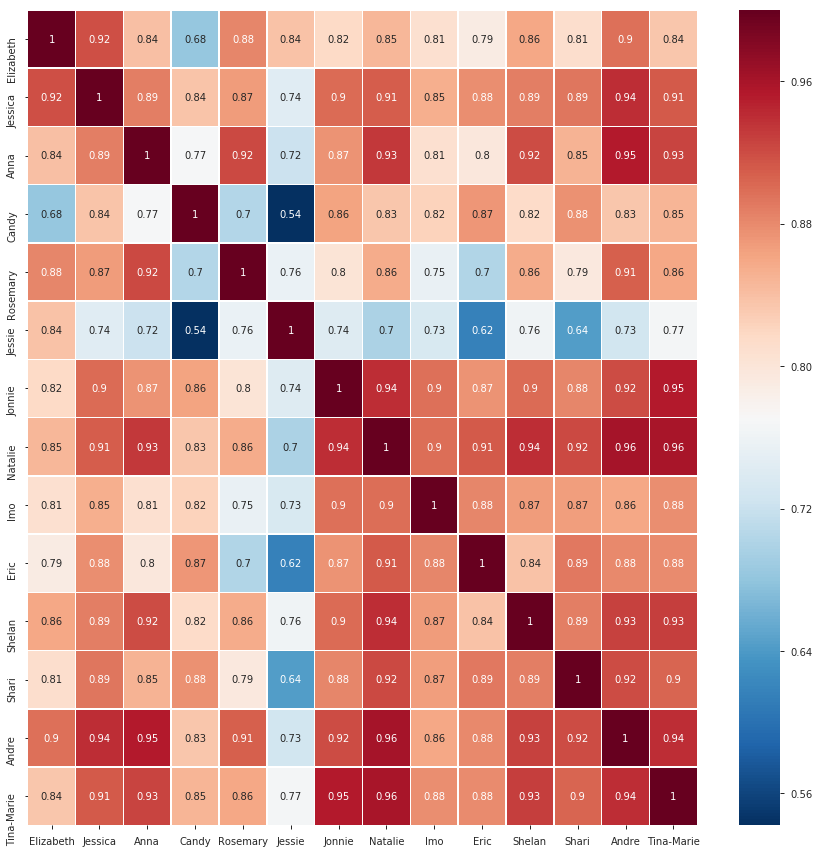

In [53]:
# Who would make the best lunch buddies?  Let's explore that question by visualizing who has the most in common with each others' tastes
test = user_score_matrix.replace("", 0)
test

my_matrix = csr_matrix(test.values)

similarity = cosine_similarity(my_matrix)

similarity

fig = plt.figure(figsize=(15,15))
sns.heatmap(similarity, 
            xticklabels=user_score_matrix.index,
            yticklabels=user_score_matrix.index,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
plt.show()

In [ ]:
# Turn the sparse matrix into a fully populated matrix with lightfm

In [ ]:
# Group the lunch buddies into k-neighbors groups (check for best k)

In [ ]:
# Get the composite user's top 5 picks

In [ ]:
# Use the FourSquare API to return the composite user's top 5 picks

In [ ]:
# Add the results to the map

In [169]:
# Now that we have the central location, we can make calls to the FourSquare API to explore which restaurants are in the area around the central location
radius = 100 # in meters
limit = 10

cat_id = food_id_dataframe[food_id_dataframe.index == 'Food']['id'].values[0]

# Creating the url for the categories API call
food_venues_url = f'https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={central_location[0]},{central_location[1]}&radius={radius}&categoryId={cat_id}&limit={limit}'
food_venues_url

# Creating the nub of the Food category dataframe with the parent cat name and id
food_response = requests.get(food_venues_url).json()
sub_cats = food_response['response']['venues']
for cat in sub_cats:
    print(cat['id'], cat['name'], cat['location']['lat'], cat['location']['lng'], cat['location']['address'], \
          [c['id'] for c in cat['categories']], \
          [c['name'] for c in cat['categories']], \
          [c['icon']['prefix']+'bg_32'+c['icon']['suffix'] for c in cat['categories']][0])
# venues_dataframe = json_normalize(cat['id'], cat['name'], cat['location']['lat'], cat['location']['lng'], cat['location']['address'], [c['id'] for c in cat['categories']], [c['name'] for c in cat['categories']], [c['icon']['prefix']+'bg_44'+c['icon']['suffix'] for c in cat['categories']][0])
# venues_dataframe = food_id_dataframe[['id', 'name']]



4a15be09f964a520c2781fe3 Tap House Grill 47.611504853338786 -122.33485797588291 1506 6th Ave ['56aa371ce4b08b9a8d57356c'] ['Beer Bar'] https://ss3.4sqi.net/img/categories_v2/nightlife/pub_bg_32.png
40b13b00f964a520dbf61ee3 Palomino 47.61041002204946 -122.33519074761 1420 5th Ave ['4bf58dd8d48988d110941735'] ['Italian Restaurant'] https://ss3.4sqi.net/img/categories_v2/food/italian_bg_32.png
47347490f964a5202b4c1fe3 Monorail Espresso 47.610827841360624 -122.33504799148172 510 Pike St ['4bf58dd8d48988d1e0931735'] ['Coffee Shop'] https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_bg_32.png
4a9c2ec7f964a520523620e3 Saigon Vietnamese Restaurant II 47.612038984694344 -122.33539688395729 1529 6th Ave ['4bf58dd8d48988d14a941735'] ['Vietnamese Restaurant'] https://ss3.4sqi.net/img/categories_v2/food/vietnamese_bg_32.png


KeyError: 'address'

In [167]:
# pearson correlation preview
user_category_matrix_column_names.pop(0)
user_category_matrix_column_names
one_hot_df = pd.get_dummies(buddy_sparse_matrix[buddy_sparse_matrix[user_category_matrix_column_names]])
one_hot_df

ValueError: Must pass DataFrame with boolean values only

## Section 3) Methodology 🔬

### I will be utilizing the LightFM module to help fit the utilization matrix into a hybrid recommender system.  This will lay the foundation for introducing new users and new categories into the lunchtime ecosystem for the purposes of generating a predicted recommendation based on the profile of the exisiting users.  I will use stochastic gradient descent to help converge the weighted approximate-ranke pairwise loss function.  Additionally, I'll tune my hyperparameters utilizing the RandomizedSearchCV to help select the optimal parameters for the LightFM model. 

## Section 4) Results 📊

## Section 5) Observations 💡

## Section 6) Conclusions ✨